#### Introduction

Credit card default prediction is a fundamental problem in financial risk management. Banks and lending institutions must assess whether a customer is likely to default on their upcoming payment cycle, as misjudging credit risk can lead to significant financial losses. Traditional credit scoring methods—such as logistic regression and manual rule-based systems—often struggle to capture non-linear patterns in customer behavior and may not fully exploit the rich historical data available.

In this project, we develop and evaluate machine learning models to predict the default payment next month using the well-known UCI “Default of Credit Card Clients” dataset. The dataset includes demographic variables, credit limits, repayment history, billing amounts, and payment behavior over six months for 30,000 credit card customers. The task is a binary classification problem with notable class imbalance (~78% non-default, 22% default).

Prior research (Yeh & Lien, 2009; Wahab et al., 2024; Bhandary & Ghosh, 2025) demonstrates that both classical models and modern ensemble or neural architectures can perform well on this dataset, with more complex models often achieving higher AUC and F1 scores. However, logistic regression remains important in real financial applications due to its interpretability and explainability requirements under regulatory guidelines.

Our notebook follows a structured ML workflow:

- Data exploration and preprocessing

- Feature encoding and standardization

- Training baseline models (Logistic Regression, Decision Tree, SVM)

- Evaluating performance using Accuracy, Precision, Recall, F1, and AUC

- Exploring ensemble methods such as Random Forest, AdaBoost, and Voting Classifiers

- Comparing model performance to identify which approach best predicts default

The goal is not only to achieve strong predictive performance but also to understand which features influence default behavior, how different models compare, and how machine learning can support real-world credit risk assessment.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, roc_auc_score, RocCurveDisplay,
                             average_precision_score)

## Step 1: Load and Explore the Dataset


In [3]:
df = pd.read_excel("/Users/priti/Documents/GitHub/Predicting-Default-of-Credit-Card-Clients/default of credit card clients.xls", header=1)

print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
display(df.head())

print("\nDataset Info:")
df.info()

Dataset Shape: (30000, 25)

First 5 rows:


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-null  in

In [4]:
# Create a copy of the original dataset
data = df.copy()

In [5]:
# drop 'ID' column as it is not needed for analysis
df = df.drop(columns=['ID'])

## Step 2: Initial Data Analysis

Check for missing values and examine class distribution.


In [6]:
# Check for missing values
print("Missing values per column:")
print(df.isna().sum())
print()

# Check class distribution (imbalance)
print("Class Distribution:")
print(df['default payment next month'].value_counts())
print("\nClass Proportions:")
print(df['default payment next month'].value_counts(normalize=True))

Missing values per column:
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64

Class Distribution:
0    23364
1     6636
Name: default payment next month, dtype: int64

Class Proportions:
0    0.7788
1    0.2212
Name: default payment next month, dtype: float64


- There are no missing values in the Dataset.


## Step 3: Split Data into Train/Validation/Test Sets

**CRITICAL:** We split BEFORE any preprocessing to prevent data leakage.

- Train: 70% (21,000 samples)
- Test: 20% (6,000 samples)
- Validation: 10% (3,000 samples)


In [7]:
# Prepare features and target
X = df.drop('default payment next month', axis=1)
y = df['default payment next month']

# Split: Train 70%, Test 20%, Validation 10%
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.125, random_state=42, stratify=y_temp
)

print("Train set size:", X_train.shape)
print("Validation set size:", X_val.shape)
print("Test set size:", X_test.shape)

# Verify class distribution is maintained
print("\nClass distribution in train set:")
print(y_train.value_counts(normalize=True))

Train set size: (21000, 23)
Validation set size: (3000, 23)
Test set size: (6000, 23)

Class distribution in train set:
0    0.77881
1    0.22119
Name: default payment next month, dtype: float64


## Step 4: Encode Categorical Variables

**Categorical Variables:**

- EDUCATION: ordinal encoding
- MARRIAGE: One-hot encoding


In [8]:
print(X_train.columns)

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'],
      dtype='object')


In [9]:
# ORDINAL + OHE ENCODING

print("Columns before encoding:", X_train.columns.tolist())

### 1. Ordinal encoding of 'EDUCATION' column

education_map = {
    1: 3,   # graduate school
    2: 2,   # university
    3: 1,   # high school
    4: 0,   # others
    5: 0,   # unknown
    6: 0,   # unknown
    0: 0    # some datasets include 0 erroneously
}

X_train["EDUCATION"] = X_train["EDUCATION"].map(education_map)
X_val["EDUCATION"]   = X_val["EDUCATION"].map(education_map)
X_test["EDUCATION"]  = X_test["EDUCATION"].map(education_map)

### ---- 2. One-hot encode MARRIAGE ----

# Only encode if column exists
if "MARRIAGE" in X_train.columns:
    X_train = pd.get_dummies(X_train, columns=["MARRIAGE"], drop_first=True)
    X_val   = pd.get_dummies(X_val,   columns=["MARRIAGE"], drop_first=True)
    X_test  = pd.get_dummies(X_test,  columns=["MARRIAGE"], drop_first=True)

# Align columns (important)
X_val  = X_val.reindex(columns=X_train.columns, fill_value=0)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

print("\nAfter encoding:")
print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape)

print("\nSample rows after encoding:")
print(X_train.head())


Columns before encoding: ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

After encoding:
Train shape: (21000, 25)
Validation shape: (3000, 25)
Test shape: (6000, 25)

Sample rows after encoding:
       LIMIT_BAL  SEX  EDUCATION  AGE  PAY_0  PAY_2  PAY_3  PAY_4  PAY_5  \
8049      240000    1          2   39     -1     -1     -1     -1     -1   
29714      20000    1          2   36      0      0      0      0      0   
21784     320000    2          1   25      0      0      0      0      0   
26932     130000    1          2   44      0      0      0     -1     -1   
21516      60000    2          2   26      2      2      2      2      2   

       PAY_6  ...  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  PAY_AMT4  \
8049      -1  ...       1761      4437     11237      4293      22

## Step 5: Standardize Numerical Features

**Important:** We fit the scaler ONLY on training data, then transform all sets.
This prevents data leakage from test/validation sets.


In [10]:
# Initialize scaler
scaler = StandardScaler()

# Identify numerical columns (exclude binary/dummy variables)
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns
# Exclude dummy variables (one-hot encoded MARRIAGE columns)
numerical_features = [
    col for col in numerical_features
    if not col.startswith("MARRIAGE_")
]

print(f"Scaling {len(numerical_features)} numerical features")

# Fit scaler ONLY on training data
scaler.fit(X_train[numerical_features])

# Transform all sets using the fitted scaler
X_train[numerical_features] = scaler.transform(X_train[numerical_features])
X_val[numerical_features] = scaler.transform(X_val[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

print("✓ Preprocessing complete!")
print("\nSample of scaled features:")
print(X_train[numerical_features].head())

Scaling 22 numerical features
✓ Preprocessing complete!

Sample of scaled features:
       LIMIT_BAL       SEX  EDUCATION       AGE     PAY_0     PAY_2     PAY_3  \
8049    0.564817 -1.242171  -0.212322  0.388307 -0.881081 -0.721980 -0.696847   
29714  -1.138243 -1.242171  -0.212322  0.062355  0.013634  0.114521  0.139943   
21784   1.184111  0.805042  -1.552897 -1.132802  0.013634  0.114521  0.139943   
26932  -0.286713 -1.242171  -0.212322  0.931561  0.013634  0.114521  0.139943   
21516  -0.828596  0.805042  -0.212322 -1.024152  1.803063  1.787523  1.813524   

          PAY_4     PAY_5     PAY_6  ...  BILL_AMT3  BILL_AMT4  BILL_AMT5  \
8049  -0.667838 -0.646962 -0.617562  ...  -0.518730  -0.618011  -0.623327   
29714  0.191091  0.239750  0.252769  ...  -0.472103  -0.426639  -0.389271   
21784  0.191091  0.239750  0.252769  ...   0.328376   0.421300   0.498200   
26932 -0.667838 -0.646962 -1.487892  ...  -0.537776  -0.469093  -0.660090   
21516  1.908949  2.013174  1.993430  ...   0

In [11]:
# Stage 1: Train models for feature importance analysis
log_reg = LogisticRegression(max_iter=1000, random_state=100, class_weight='balanced')
rf_clf = RandomForestClassifier(n_estimators=100, random_state=100, class_weight='balanced')

log_reg.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)
print("✓ LR and RF trained for feature importance analysis")

✓ LR and RF trained for feature importance analysis


LOGISTIC REGRESSION - Top 20 Features
PAY_0         0.597502
MARRIAGE_3    0.412920
MARRIAGE_1    0.378905
BILL_AMT1     0.281062
MARRIAGE_2    0.220554
PAY_AMT2      0.180938
PAY_AMT1      0.171366
LIMIT_BAL     0.128651
BILL_AMT3     0.116038
PAY_3         0.109373
PAY_2         0.106216
EDUCATION     0.086514
BILL_AMT4     0.070517
PAY_AMT4      0.067463
AGE           0.064660
BILL_AMT5     0.063172
BILL_AMT2     0.049005
SEX           0.047999
BILL_AMT6     0.038832
PAY_4         0.033647
dtype: float64

RANDOM FOREST - Top 20 Features
PAY_0        0.096416
LIMIT_BAL    0.062766
BILL_AMT1    0.061701
AGE          0.061415
PAY_AMT1     0.053736
BILL_AMT2    0.053299
PAY_AMT2     0.051373
BILL_AMT3    0.049743
PAY_AMT3     0.049240
BILL_AMT4    0.049065
BILL_AMT5    0.047725
BILL_AMT6    0.047565
PAY_2        0.047205
PAY_AMT6     0.046077
PAY_AMT4     0.043376
PAY_AMT5     0.043188
PAY_3        0.034064
PAY_4        0.019808
PAY_5        0.019728
EDUCATION    0.019197
dtype: float64

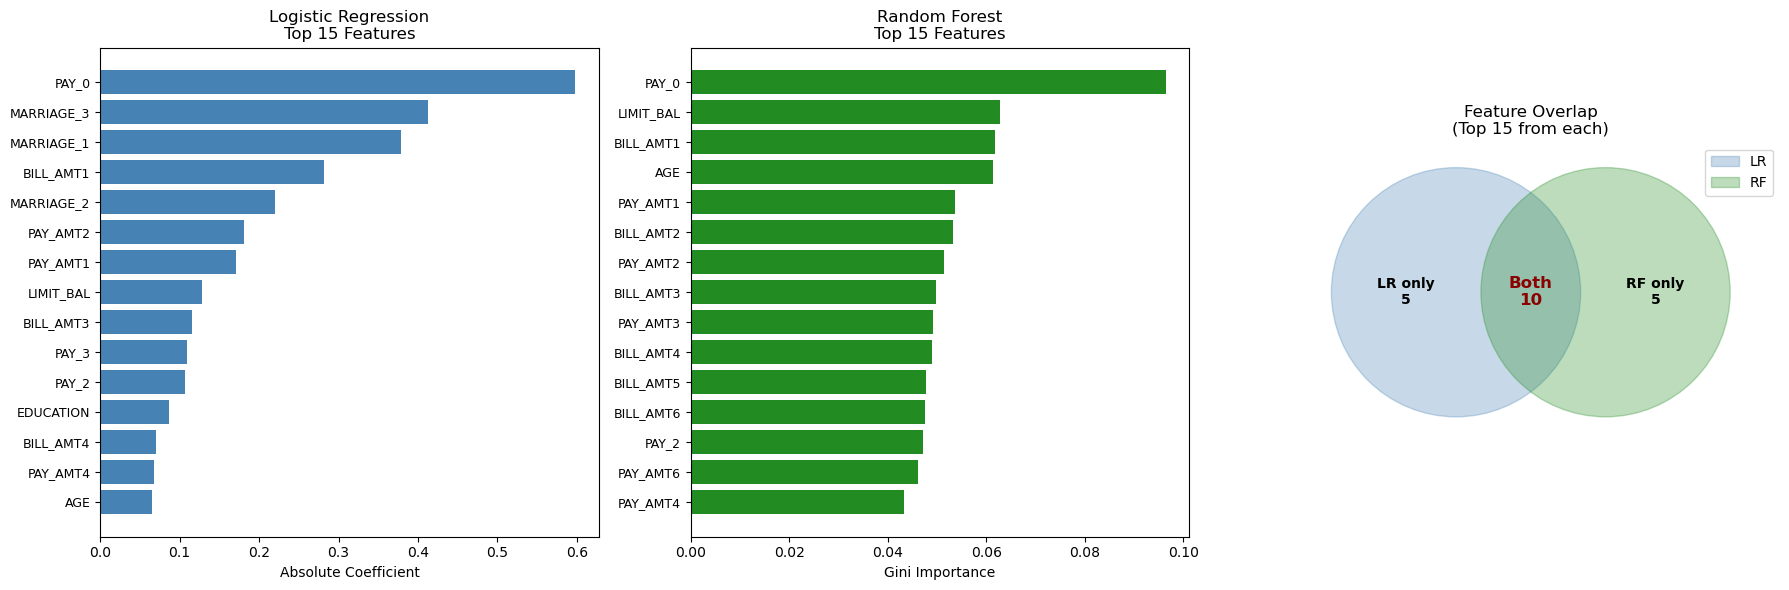

✓ FEATURE SELECTION COMPLETE
Original features: 25
Selected features (overlap): 10
Selected features (union): 20

New datasets created:
  X_train_selected: (21000, 10)
  X_val_selected: (3000, 10)
  X_test_selected: (6000, 10)

Selected features list:
['BILL_AMT1', 'AGE', 'PAY_AMT2', 'LIMIT_BAL', 'PAY_AMT1', 'PAY_2', 'PAY_0', 'BILL_AMT3', 'PAY_AMT4', 'BILL_AMT4']

Next step: Train your models on X_train_selected, X_val_selected


In [12]:
"""
Simple Feature Selection Using LR Coefficients + RF Feature Importance
Goal: Select the overlap/intersection of top features from both models
"""

# STEP 1: Get Feature Importance from Logistic Regression

# Get LR coefficients (absolute values)
lr_importance = pd.Series(
    np.abs(log_reg.coef_[0]), 
    index=X_train.columns
).sort_values(ascending=False)

print("="*70)
print("LOGISTIC REGRESSION - Top 20 Features")
print("="*70)
print(lr_importance.head(20))
print()

# STEP 2: Get Feature Importance from Random Forest

# Get RF feature importance
rf_importance = pd.Series(
    rf_clf.feature_importances_, 
    index=X_train.columns
).sort_values(ascending=False)

print("="*70)
print("RANDOM FOREST - Top 20 Features")
print("="*70)
print(rf_importance.head(20))
print()

# STEP 3: Select Top N Features from Each Model

# Choose how many top features to consider from each model
top_n = 15  # Adjust this number as needed

# Get top features from each model
top_lr_features = set(lr_importance.head(top_n).index)
top_rf_features = set(rf_importance.head(top_n).index)

print("="*70)
print(f"Top {top_n} features from Logistic Regression:")
print("="*70)
print(list(top_lr_features))
print()

print("="*70)
print(f"Top {top_n} features from Random Forest:")
print("="*70)
print(list(top_rf_features))
print()

# STEP 4: Get Overlap (Intersection) - Features Important in BOTH


# Features that appear in top N of BOTH models
selected_features_overlap = list(top_lr_features.intersection(top_rf_features))

print("="*70)
print(f"🎯 SELECTED FEATURES (Overlap - Top {top_n} from BOTH models)")
print("="*70)
print(f"Number of features: {len(selected_features_overlap)}")
print(selected_features_overlap)
print()


# OPTIONAL: Get Union - Features Important in EITHER Model

# Features that appear in top N of EITHER model (more inclusive)
selected_features_union = list(top_lr_features.union(top_rf_features))

print("="*70)
print(f"ALTERNATIVE: Union (Top {top_n} from EITHER model)")
print("="*70)
print(f"Number of features: {len(selected_features_union)}")
print(selected_features_union)
print()


# STEP 5: Visualize the Selection

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# LR Top Features
top_lr_vis = lr_importance.head(15)
axes[0].barh(range(len(top_lr_vis)), top_lr_vis.values, color='steelblue')
axes[0].set_yticks(range(len(top_lr_vis)))
axes[0].set_yticklabels(top_lr_vis.index, fontsize=9)
axes[0].set_xlabel('Absolute Coefficient')
axes[0].set_title(f'Logistic Regression\nTop {len(top_lr_vis)} Features')
axes[0].invert_yaxis()

# RF Top Features
top_rf_vis = rf_importance.head(15)
axes[1].barh(range(len(top_rf_vis)), top_rf_vis.values, color='forestgreen')
axes[1].set_yticks(range(len(top_rf_vis)))
axes[1].set_yticklabels(top_rf_vis.index, fontsize=9)
axes[1].set_xlabel('Gini Importance')
axes[1].set_title(f'Random Forest\nTop {len(top_rf_vis)} Features')
axes[1].invert_yaxis()

# Venn Diagram Visualization (conceptual)
from matplotlib.patches import Circle
axes[2].set_xlim(0, 10)
axes[2].set_ylim(0, 10)
axes[2].set_aspect('equal')

# Draw circles
circle1 = Circle((3.5, 5), 2.5, color='steelblue', alpha=0.3, label='LR')
circle2 = Circle((6.5, 5), 2.5, color='forestgreen', alpha=0.3, label='RF')
axes[2].add_patch(circle1)
axes[2].add_patch(circle2)

# Add text
axes[2].text(2.5, 5, f'LR only\n{len(top_lr_features - top_rf_features)}', 
             ha='center', va='center', fontsize=10, weight='bold')
axes[2].text(7.5, 5, f'RF only\n{len(top_rf_features - top_lr_features)}', 
             ha='center', va='center', fontsize=10, weight='bold')
axes[2].text(5, 5, f'Both\n{len(selected_features_overlap)}', 
             ha='center', va='center', fontsize=12, weight='bold', color='darkred')

axes[2].set_xlim(0, 10)
axes[2].set_ylim(2, 8)
axes[2].axis('off')
axes[2].set_title(f'Feature Overlap\n(Top {top_n} from each)')
axes[2].legend(loc='upper right')

plt.tight_layout()
plt.show()

# =============================================================================
# STEP 6: Create Reduced Feature Sets
# =============================================================================

# Create new datasets with only selected features (OVERLAP)
X_train_selected = X_train[selected_features_overlap]
X_val_selected = X_val[selected_features_overlap]
X_test_selected = X_test[selected_features_overlap]

print("="*70)
print("✓ FEATURE SELECTION COMPLETE")
print("="*70)
print(f"Original features: {X_train.shape[1]}")
print(f"Selected features (overlap): {X_train_selected.shape[1]}")
print(f"Selected features (union): {len(selected_features_union)}")
print()
print("New datasets created:")
print(f"  X_train_selected: {X_train_selected.shape}")
print(f"  X_val_selected: {X_val_selected.shape}")
print(f"  X_test_selected: {X_test_selected.shape}")
print()
print("Selected features list:")
print(selected_features_overlap)
print()
print("="*70)
print("Next step: Train your models on X_train_selected, X_val_selected")
print("="*70)

## Step 6: Train Baseline Models

We train three baseline models with `class_weight='balanced'` to handle class imbalance:

1. Logistic Regression
2. Decision Tree
3. Support Vector Machine (SVM)


In [25]:
# balancing the classes using class_weight parameter in Logistic Regression
log_reg = LogisticRegression(
    max_iter=1000, 
    random_state=100,
    class_weight={0: 3.0, 1: 4.0} 
)

# Train models
print("Training Logistic Regression...")
log_reg.fit(X_train, y_train)

def evaluate_model(model, X_val, y_val):
    """Evaluate model and return key metrics"""
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:, 1]
    
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, zero_division=0)
    recall = recall_score(y_val, y_pred, zero_division=0)
    f1 = f1_score(y_val, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_val, y_proba)
    
    return accuracy, precision, recall, f1, roc_auc

# Evaluate all models
log_reg_metrics = evaluate_model(log_reg, X_val, y_val)


# Display results
print("="*70)
print("BASELINE MODEL PERFORMANCE -  (Validation Set)")
print("="*70)
print(f"Logistic Regression - Accuracy: {log_reg_metrics[0]:.4f}, Precision: {log_reg_metrics[1]:.4f}, "
      f"Recall: {log_reg_metrics[2]:.4f}, F1: {log_reg_metrics[3]:.4f}, ROC-AUC: {log_reg_metrics[4]:.4f}")

print("="*70)
print("\n⚠️ NOTE: Pay attention to Recall (sensitivity to defaults)!")
print("   Low recall means the model misses many actual defaults.")


Training Logistic Regression...
BASELINE MODEL PERFORMANCE -  (Validation Set)
Logistic Regression - Accuracy: 0.8143, Precision: 0.6516, Recall: 0.3464, F1: 0.4523, ROC-AUC: 0.7243

⚠️ NOTE: Pay attention to Recall (sensitivity to defaults)!
   Low recall means the model misses many actual defaults.


In [27]:
# Evaluate all models
log_reg_metrics = evaluate_model(log_reg, X_test, y_test)
# Display results
print("="*70)
print("BASELINE MODEL PERFORMANCE -  (Validation Set)")
print("="*70)
print(f"Logistic Regression - Accuracy: {log_reg_metrics[0]:.4f}, Precision: {log_reg_metrics[1]:.4f}, "
      f"Recall: {log_reg_metrics[2]:.4f}, F1: {log_reg_metrics[3]:.4f}, ROC-AUC: {log_reg_metrics[4]:.4f}")

print("="*70)
print("\n⚠️ NOTE: Pay attention to Recall (sensitivity to defaults)!")
print("   Low recall means the model misses many actual defaults.")

BASELINE MODEL PERFORMANCE -  (Validation Set)
Logistic Regression - Accuracy: 0.8132, Precision: 0.6463, Recall: 0.3429, F1: 0.4481, ROC-AUC: 0.7083

⚠️ NOTE: Pay attention to Recall (sensitivity to defaults)!
   Low recall means the model misses many actual defaults.


In [ ]:
# Initialize models WITHOUT class_weight='balanced'(without feature impotance based selection)
log_reg = LogisticRegression(
    max_iter=1000, 
    random_state=100
)

dec_tree = DecisionTreeClassifier(
    random_state=100
)

svm = SVC(
    random_state=100,
    probability=True  # Needed for predict_proba
)

# Train models
print("Training Logistic Regression (unbalanced)...")
log_reg.fit(X_train, y_train)

print("Training Decision Tree (unbalanced)...")
dec_tree.fit(X_train, y_train)

print("Training SVM (unbalanced)...")
svm.fit(X_train, y_train)

print("✓ Baseline models trained successfully (without class balancing)!")

# =============================================================================
# CELL 8: Evaluate Models on Validation Set (Unbalanced)
# =============================================================================
"""
## Step 7: Evaluate Baseline Models (Without Balancing)

Metrics used:
- **Accuracy:** Overall correctness
- **Precision:** Of predicted defaults, how many are correct?
- **Recall:** Of actual defaults, how many did we catch?
- **F1-Score:** Harmonic mean of precision and recall (important for imbalanced data)
- **ROC-AUC:** Area under ROC curve (threshold-independent metric)

**Expected Issue:** Without balancing, models may have high accuracy but poor recall
(they'll predict "no default" too often).
"""

def evaluate_model(model, X_val, y_val):
    """Evaluate model and return key metrics"""
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:, 1]
    
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, zero_division=0)
    recall = recall_score(y_val, y_pred, zero_division=0)
    f1 = f1_score(y_val, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_val, y_proba)
    
    return accuracy, precision, recall, f1, roc_auc

# Evaluate all models
log_reg_metrics = evaluate_model(log_reg, X_val, y_val)
dec_tree_metrics = evaluate_model(dec_tree, X_val, y_val)
svm_metrics = evaluate_model(svm, X_val, y_val)

# Display results
print("="*70)
print("BASELINE MODEL PERFORMANCE - WITHOUT BALANCING (Validation Set)")
print("="*70)
print(f"Logistic Regression - Accuracy: {log_reg_metrics[0]:.4f}, Precision: {log_reg_metrics[1]:.4f}, "
      f"Recall: {log_reg_metrics[2]:.4f}, F1: {log_reg_metrics[3]:.4f}, ROC-AUC: {log_reg_metrics[4]:.4f}")
print(f"Decision Tree       - Accuracy: {dec_tree_metrics[0]:.4f}, Precision: {dec_tree_metrics[1]:.4f}, "
      f"Recall: {dec_tree_metrics[2]:.4f}, F1: {dec_tree_metrics[3]:.4f}, ROC-AUC: {dec_tree_metrics[4]:.4f}")
print(f"SVM                 - Accuracy: {svm_metrics[0]:.4f}, Precision: {svm_metrics[1]:.4f}, "
      f"Recall: {svm_metrics[2]:.4f}, F1: {svm_metrics[3]:.4f}, ROC-AUC: {svm_metrics[4]:.4f}")
print("="*70)
print("\n⚠️ NOTE: Pay attention to Recall (sensitivity to defaults)!")
print("   Low recall means the model misses many actual defaults.")

Training Logistic Regression (unbalanced)...
Training Decision Tree (unbalanced)...
Training SVM (unbalanced)...
✓ Baseline models trained successfully (without class balancing)!
BASELINE MODEL PERFORMANCE - WITHOUT BALANCING (Validation Set)
Logistic Regression - Accuracy: 0.8133, Precision: 0.7016, Recall: 0.2726, F1: 0.3926, ROC-AUC: 0.7240
Decision Tree       - Accuracy: 0.7263, Precision: 0.3926, Recall: 0.4322, F1: 0.4115, ROC-AUC: 0.6210
SVM                 - Accuracy: 0.8200, Precision: 0.6824, Recall: 0.3494, F1: 0.4622, ROC-AUC: 0.7279

⚠️ NOTE: Pay attention to Recall (sensitivity to defaults)!
   Low recall means the model misses many actual defaults.


In [14]:
# Initialize models WITHOUT class_weight='balanced' with feature importance selected features
log_reg = LogisticRegression(
    max_iter=1000, 
    random_state=100
)

dec_tree = DecisionTreeClassifier(
    random_state=100
)

svm = SVC(
    random_state=100,
    probability=True  # Needed for predict_proba
)

# Train models
print("Training Logistic Regression (unbalanced)...")
log_reg.fit(X_train_selected, y_train)

print("Training Decision Tree (unbalanced)...")
dec_tree.fit(X_train_selected, y_train)

print("Training SVM (unbalanced)...")
svm.fit(X_train_selected, y_train)

print("✓ Baseline models trained successfully (without class balancing)!")

# =============================================================================
# CELL 8: Evaluate Models on Validation Set (Unbalanced)
# =============================================================================
"""
## Step 7: Evaluate Baseline Models (Without Balancing)

Metrics used:
- **Accuracy:** Overall correctness
- **Precision:** Of predicted defaults, how many are correct?
- **Recall:** Of actual defaults, how many did we catch?
- **F1-Score:** Harmonic mean of precision and recall (important for imbalanced data)
- **ROC-AUC:** Area under ROC curve (threshold-independent metric)

**Expected Issue:** Without balancing, models may have high accuracy but poor recall
(they'll predict "no default" too often).
"""

def evaluate_model(model, X_val, y_val):
    """Evaluate model and return key metrics"""
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:, 1]
    
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, zero_division=0)
    recall = recall_score(y_val, y_pred, zero_division=0)
    f1 = f1_score(y_val, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_val, y_proba)
    
    return accuracy, precision, recall, f1, roc_auc

# Evaluate all models
log_reg_metrics = evaluate_model(log_reg, X_val_selected, y_val)
dec_tree_metrics = evaluate_model(dec_tree, X_val_selected, y_val)
svm_metrics = evaluate_model(svm, X_val_selected, y_val)

# Display results
print("="*70)
print("BASELINE MODEL PERFORMANCE - WITHOUT BALANCING (Validation Set)")
print("="*70)
print(f"Logistic Regression - Accuracy: {log_reg_metrics[0]:.4f}, Precision: {log_reg_metrics[1]:.4f}, "
      f"Recall: {log_reg_metrics[2]:.4f}, F1: {log_reg_metrics[3]:.4f}, ROC-AUC: {log_reg_metrics[4]:.4f}")
print(f"Decision Tree       - Accuracy: {dec_tree_metrics[0]:.4f}, Precision: {dec_tree_metrics[1]:.4f}, "
      f"Recall: {dec_tree_metrics[2]:.4f}, F1: {dec_tree_metrics[3]:.4f}, ROC-AUC: {dec_tree_metrics[4]:.4f}")
print(f"SVM                 - Accuracy: {svm_metrics[0]:.4f}, Precision: {svm_metrics[1]:.4f}, "
      f"Recall: {svm_metrics[2]:.4f}, F1: {svm_metrics[3]:.4f}, ROC-AUC: {svm_metrics[4]:.4f}")
print("="*70)
print("\n⚠️ NOTE: Pay attention to Recall (sensitivity to defaults)!")
print("   Low recall means the model misses many actual defaults.")

Training Logistic Regression (unbalanced)...
Training Decision Tree (unbalanced)...
Training SVM (unbalanced)...
✓ Baseline models trained successfully (without class balancing)!
BASELINE MODEL PERFORMANCE - WITHOUT BALANCING (Validation Set)
Logistic Regression - Accuracy: 0.8093, Precision: 0.6885, Recall: 0.2530, F1: 0.3700, ROC-AUC: 0.7160
Decision Tree       - Accuracy: 0.7100, Precision: 0.3593, Recall: 0.3961, F1: 0.3768, ROC-AUC: 0.5979
SVM                 - Accuracy: 0.8220, Precision: 0.7181, Recall: 0.3223, F1: 0.4449, ROC-AUC: 0.7345

⚠️ NOTE: Pay attention to Recall (sensitivity to defaults)!
   Low recall means the model misses many actual defaults.


In [13]:
# Initialize models with class_weight='balanced'
log_reg = LogisticRegression(
    max_iter=1000, 
    random_state=100, 
    class_weight='balanced'
)

dec_tree = DecisionTreeClassifier(
    random_state=100, 
    class_weight='balanced'
)

svm = SVC(
    random_state=100, 
    class_weight='balanced',
    probability=True  # Needed for predict_proba
)


rf_clf = RandomForestClassifier(
    n_estimators=100, 
    random_state=100, 
    class_weight='balanced'
)
# Train models
print("Training Logistic Regression...")
log_reg.fit(X_train_selected, y_train)

print("Training Decision Tree...")
dec_tree.fit(X_train_selected, y_train)

print("Training SVM...")
svm.fit(X_train_selected, y_train)

print("Training Random Forest...")
rf_clf.fit(X_train_selected, y_train)

print("✓ Baseline models trained successfully!")

Training Logistic Regression...
Training Decision Tree...
Training SVM...
Training Random Forest...
✓ Baseline models trained successfully!


In [16]:
# =============================================================================
# CELL 7: Define Baseline & Cost-Sensitive Models
# =============================================================================
"""
We now define:
1. Baseline Logistic Regression (class_weight='balanced')
2. Cost-sensitive Logistic Regression (heavier penalty on default = 1)
3. Decision Tree (with class weights)
4. SVM with RBF kernel (with class weights)

We will evaluate them and then build a weighted soft-voting ensemble.
"""


# Baseline Logistic Regression (balanced)
log_reg_base = LogisticRegression(
    max_iter=1000,
    random_state=100,
    class_weight='balanced'   # balances minority/majority automatically
)

# Cost-sensitive Logistic Regression (manual weights)
# Give default class (1) higher weight than non-default (0)
log_reg_cost = LogisticRegression(
    max_iter=1000,
    random_state=100,
    class_weight={0: 1.0, 1: 3.0}   # you can tune 3.0 → 2.0, 4.0, etc.
)

# Decision Tree (cost-sensitive)
dec_tree_cost = DecisionTreeClassifier(
    random_state=100,
    class_weight={0: 1.0, 1: 3.0},  # similar idea: penalize misclassifying defaulters
    min_samples_split=20,
    min_samples_leaf=10
)

# SVM (RBF) (cost-sensitive)
svm_cost = SVC(
    random_state=100,
    class_weight={0: 1.0, 1: 3.0},
    probability=True  # needed for predict_proba and ROC
)

print("✓ Models defined (baseline LR, cost-sensitive LR, DT, SVM)")


✓ Models defined (baseline LR, cost-sensitive LR, DT, SVM)


In [21]:
# =============================================================================
# CELL 8: Helper Function for Evaluation
# =============================================================================
"""
We will use one function to compute:
- Accuracy
- Precision
- Recall
- F1-Score
- ROC-AUC
and print a nice summary.
"""

from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix)

def evaluate_model(name, model, X_val, y_val):
    """Fit model (if not already), predict on validation, and print metrics."""
    y_pred = model.predict(X_val_selected)
    y_proba = model.predict_proba(X_val_selected)[:, 1]

    acc  = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred)
    rec  = recall_score(y_val, y_pred)
    f1   = f1_score(y_val, y_pred)
    auc  = roc_auc_score(y_val, y_proba)

    print(f"\n=== {name} ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-Score : {f1:.4f}")
    print(f"AUC-ROC  : {auc:.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_val, y_pred))

    return acc, prec, rec, f1, auc


In [22]:
# =============================================================================
# CELL 9: Train & Evaluate Individual Models
# =============================================================================
"""
Train:
- Logistic Regression (baseline)
- Logistic Regression (cost-sensitive)
- Decision Tree (cost-sensitive)
- SVM (cost-sensitive)

Evaluate all on validation set.
"""

# Fit models
print("Training baseline Logistic Regression...")
log_reg_base.fit(X_train_selected, y_train)

print("Training cost-sensitive Logistic Regression...")
log_reg_cost.fit(X_train_selected, y_train)

print("Training cost-sensitive Decision Tree...")
dec_tree_cost.fit(X_train_selected, y_train)

print("Training cost-sensitive SVM...")
svm_cost.fit(X_train_selected, y_train)

# Evaluate on validation set
results_list = []

metrics_lr_base = evaluate_model("Logistic Regression (baseline)",       log_reg_base, X_val_selected, y_val)
metrics_lr_cost = evaluate_model("Logistic Regression (cost-sensitive)", log_reg_cost, X_val_selected, y_val)
metrics_dt_cost = evaluate_model("Decision Tree (cost-sensitive)",       dec_tree_cost, X_val_selected, y_val)
metrics_svm_cost = evaluate_model("SVM (RBF, cost-sensitive)",           svm_cost, X_val_selected, y_val)

results_list.append(("Logistic Regression (baseline)",)       + metrics_lr_base)
results_list.append(("Logistic Regression (cost-sensitive)",) + metrics_lr_cost)
results_list.append(("Decision Tree (cost-sensitive)",)       + metrics_dt_cost)
results_list.append(("SVM (RBF, cost-sensitive)",)            + metrics_svm_cost)

# Build a nice DataFrame for comparison
results_df = pd.DataFrame(
    results_list,
    columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC"]
)

print("\n" + "="*80)
print("INDIVIDUAL MODEL PERFORMANCE (Validation Set)")
print("="*80)
print(results_df.to_string(index=False))
print("="*80)


Training baseline Logistic Regression...
Training cost-sensitive Logistic Regression...
Training cost-sensitive Decision Tree...
Training cost-sensitive SVM...

=== Logistic Regression (baseline) ===
Accuracy : 0.6917
Precision: 0.3821
Recall   : 0.6370
F1-Score : 0.4777
AUC-ROC  : 0.7169
Confusion Matrix:
[[1652  684]
 [ 241  423]]

=== Logistic Regression (cost-sensitive) ===
Accuracy : 0.7730
Precision: 0.4883
Recall   : 0.5361
F1-Score : 0.5111
AUC-ROC  : 0.7167
Confusion Matrix:
[[1963  373]
 [ 308  356]]

=== Decision Tree (cost-sensitive) ===
Accuracy : 0.6880
Precision: 0.3648
Recall   : 0.5527
F1-Score : 0.4395
AUC-ROC  : 0.6986
Confusion Matrix:
[[1697  639]
 [ 297  367]]

=== SVM (RBF, cost-sensitive) ===
Accuracy : 0.7863
Precision: 0.5175
Recall   : 0.5136
F1-Score : 0.5155
AUC-ROC  : 0.7560
Confusion Matrix:
[[2018  318]
 [ 323  341]]

INDIVIDUAL MODEL PERFORMANCE (Validation Set)
                               Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
      

In [23]:
# =============================================================================
# CELL 10: Weighted Soft-Voting Ensemble (LR_cost + DT + SVM)
# =============================================================================
"""
We now create a *novel ensemble* by combining:
- Cost-sensitive Logistic Regression
- Cost-sensitive Decision Tree
- Cost-sensitive SVM

We use:
- Soft voting (average predicted probabilities)
- Weights to slightly favor LR (stable + interpretable)
"""

ensemble_clf = VotingClassifier(
    estimators=[
        ('lr_cost', log_reg_cost),
        ('dt_cost', dec_tree_cost),
        ('svm_cost', svm_cost)
    ],
    voting='soft',
    weights=[1, 1, 4],   # you can experiment with [2,1,1], [4,2,2], etc.
    n_jobs=-1
)

print("Training weighted soft-voting ensemble...")
ensemble_clf.fit(X_train_selected, y_train)

ensemble_metrics = evaluate_model("Ensemble (LR_cost + DT + SVM)", ensemble_clf, X_val_selected, y_val)


Training weighted soft-voting ensemble...

=== Ensemble (LR_cost + DT + SVM) ===
Accuracy : 0.8023
Precision: 0.5644
Recall   : 0.4684
F1-Score : 0.5119
AUC-ROC  : 0.7368
Confusion Matrix:
[[2096  240]
 [ 353  311]]


In [29]:
# =============================================================================
# CELL 11: Final Comparison Table (Including Ensemble)
# =============================================================================

# Add ensemble results to previous results_df
results_df = pd.concat([
    results_df,
    pd.DataFrame([("Ensemble (LR_cost + DT + SVM)",) + ensemble_metrics],
                 columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC"])
], ignore_index=True)

print("\n" + "="*90)
print("FINAL MODEL COMPARISON (Validation Set)")
print("="*90)
print(results_df.sort_values("ROC-AUC", ascending=False).to_string(index=False))
print("="*90)



FINAL MODEL COMPARISON (Validation Set)
                               Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
           SVM (RBF, cost-sensitive)  0.786333   0.517451 0.513554  0.515495 0.755996
       Ensemble (LR_cost + DT + SVM)  0.802333   0.564428 0.468373  0.511934 0.736761
       Ensemble (LR_cost + DT + SVM)  0.802333   0.564428 0.468373  0.511934 0.736761
      Logistic Regression (baseline)  0.691667   0.382114 0.637048  0.477696 0.716883
Logistic Regression (cost-sensitive)  0.773000   0.488340 0.536145  0.511127 0.716701
      Decision Tree (cost-sensitive)  0.688000   0.364811 0.552711  0.439521 0.698641


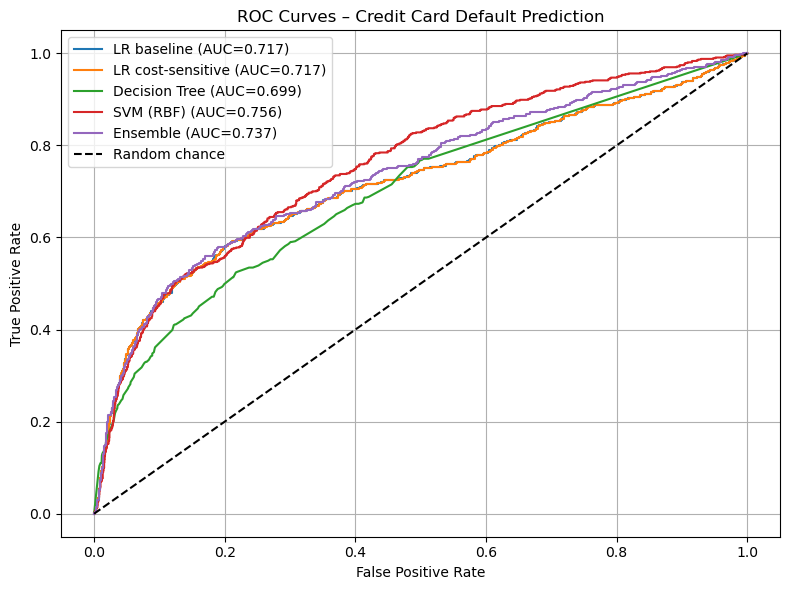

In [30]:
# =============================================================================
# CELL 12: ROC Curves for Main Models (Optional but Great for Slides)
# =============================================================================
from sklearn.metrics import roc_curve

plt.figure(figsize=(8, 6))

models_for_roc = [
    ("LR baseline", log_reg_base),
    ("LR cost-sensitive", log_reg_cost),
    ("Decision Tree", dec_tree_cost),
    ("SVM (RBF)", svm_cost),
    ("Ensemble", ensemble_clf)
]

for name, model in models_for_roc:
    y_proba = model.predict_proba(X_val_selected)[:, 1]
    fpr, tpr, _ = roc_curve(y_val, y_proba)
    auc_val = roc_auc_score(y_val, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc_val:.3f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random chance')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves – Credit Card Default Prediction")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Step 7: Evaluate Baseline Models

Metrics used:

- **Accuracy:** Overall correctness
- **Precision:** Of predicted defaults, how many are correct?
- **Recall:** Of actual defaults, how many did we catch?
- **F1-Score:** Harmonic mean of precision and recall (important for imbalanced data)
- **ROC-AUC:** Area under ROC curve (threshold-independent metric)


In [28]:
def evaluate_model(model, X_val, y_val):
    """Evaluate model and return key metrics"""
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:, 1]
    
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_proba)
    
    return accuracy, precision, recall, f1, roc_auc

# Evaluate all models
log_reg_metrics = evaluate_model(log_reg, X_val_selected, y_val)
dec_tree_metrics = evaluate_model(dec_tree, X_val_selected, y_val)
svm_metrics = evaluate_model(svm, X_val_selected, y_val)

# Display results
print("="*70)
print("BASELINE MODEL PERFORMANCE (Validation Set)")
print("="*70)
print(f"Logistic Regression - Accuracy: {log_reg_metrics[0]:.4f}, Precision: {log_reg_metrics[1]:.4f}, "
      f"Recall: {log_reg_metrics[2]:.4f}, F1: {log_reg_metrics[3]:.4f}, ROC-AUC: {log_reg_metrics[4]:.4f}")
print(f"Decision Tree       - Accuracy: {dec_tree_metrics[0]:.4f}, Precision: {dec_tree_metrics[1]:.4f}, "
      f"Recall: {dec_tree_metrics[2]:.4f}, F1: {dec_tree_metrics[3]:.4f}, ROC-AUC: {dec_tree_metrics[4]:.4f}")
print(f"SVM                 - Accuracy: {svm_metrics[0]:.4f}, Precision: {svm_metrics[1]:.4f}, "
      f"Recall: {svm_metrics[2]:.4f}, F1: {svm_metrics[3]:.4f}, ROC-AUC: {svm_metrics[4]:.4f}")
print("="*70)


BASELINE MODEL PERFORMANCE (Validation Set)
Logistic Regression - Accuracy: 0.6917, Precision: 0.3821, Recall: 0.6370, F1: 0.4777, ROC-AUC: 0.7169
Decision Tree       - Accuracy: 0.7340, Precision: 0.3919, Recall: 0.3660, F1: 0.3785, ROC-AUC: 0.6020
SVM                 - Accuracy: 0.7793, Precision: 0.5014, Recall: 0.5211, F1: 0.5111, ROC-AUC: 0.7612


# we have made blueprint till this point , can be experimented.

#### After this earlier work is there


## Step 8: Feature Importance Analysis

Analyze logistic regression coefficients to understand which features are most important
for predicting default.


In [ ]:
# Get feature weights
log_reg_weights = pd.Series(log_reg.coef_[0], index=X_train.columns)

print("Top 10 Most Important Features (by absolute weight):")
print(log_reg_weights.abs().sort_values(ascending=False).head(10))

print("\n" + "="*70)
print("All Feature Weights (sorted by value):")
print("="*70)
print(log_reg_weights.sort_values(ascending=False))

## Step 9: Feature Selection

Remove features with weights between -0.1 and 0.1 (low importance) and retrain.


In [ ]:
# Filter features with weights outside [-0.1, 0.1]
log_reg_weights_filtered = log_reg_weights[
    (log_reg_weights > 0.1) | (log_reg_weights < -0.1)
]

print(f"Original features: {len(log_reg_weights)}")
print(f"Features after filtering: {len(log_reg_weights_filtered)}")
print(f"Removed: {len(log_reg_weights) - len(log_reg_weights_filtered)} features")

print("\nRemaining features:")
print(log_reg_weights_filtered.sort_values(ascending=False))

# Create reduced feature sets
features_to_keep = log_reg_weights_filtered.index
X_train_reduced = X_train[features_to_keep]
X_val_reduced = X_val[features_to_keep]

# Train reduced model
log_reg_reduced = LogisticRegression(
    max_iter=1000, 
    random_state=100, 
    class_weight='balanced'
)
log_reg_reduced.fit(X_train_reduced, y_train)

# Evaluate reduced model
log_reg_reduced_metrics = evaluate_model(log_reg_reduced, X_val_reduced, y_val)

print("\n" + "="*70)
print("COMPARISON: Full vs Reduced Logistic Regression")
print("="*70)
print(f"Full Model    - Accuracy: {log_reg_metrics[0]:.4f}, Precision: {log_reg_metrics[1]:.4f}, "
      f"Recall: {log_reg_metrics[2]:.4f}, F1: {log_reg_metrics[3]:.4f}, ROC-AUC: {log_reg_metrics[4]:.4f}")
print(f"Reduced Model - Accuracy: {log_reg_reduced_metrics[0]:.4f}, Precision: {log_reg_reduced_metrics[1]:.4f}, "
      f"Recall: {log_reg_reduced_metrics[2]:.4f}, F1: {log_reg_reduced_metrics[3]:.4f}, ROC-AUC: {log_reg_reduced_metrics[4]:.4f}")
print("="*70)


## Step 10: Detailed Evaluation - Confusion Matrices and ROC Curves

Visualize model performance with confusion matrices and ROC curves.


In [ ]:
def plot_confusion_matrix(cm, title):
    """Plot confusion matrix as heatmap"""
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

def additional_evaluation(model, X_val, y_val, model_name):
    """Generate confusion matrix and ROC curve"""
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:, 1]
    
    cm = confusion_matrix(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_proba)
    
    # Plot confusion matrix
    plot_confusion_matrix(cm, f"{model_name} - Confusion Matrix")
    
    # Plot ROC curve
    RocCurveDisplay.from_estimator(model, X_val, y_val)
    plt.title(f"{model_name} - ROC Curve")
    plt.show()
    
    return cm, roc_auc

# Evaluate Logistic Regression
log_reg_cm, log_reg_roc_auc = additional_evaluation(log_reg, X_val, y_val, "Logistic Regression")
print(f"Logistic Regression - ROC-AUC: {log_reg_roc_auc:.4f}")

# Evaluate Decision Tree
dec_tree_cm, dec_tree_roc_auc = additional_evaluation(dec_tree, X_val, y_val, "Decision Tree")
print(f"Decision Tree - ROC-AUC: {dec_tree_roc_auc:.4f}")

## Step 11: Train Ensemble Models

Ensemble methods often perform better by combining multiple models:

1. **Random Forest:** Ensemble of decision trees
2. **Voting Classifier:** Combines Logistic Regression + Decision Tree predictions
3. **AdaBoost:** Boosting algorithm that focuses on misclassified examples


In [ ]:
# Random Forest
rf_clf = RandomForestClassifier(
    n_estimators=100, 
    random_state=100, 
    class_weight='balanced'
)

# Voting Classifier (soft voting uses probability predictions)
voting_clf = VotingClassifier(
    estimators=[('log_reg', log_reg), ('dec_tree', dec_tree)], 
    voting='soft'
)

# AdaBoost with balanced decision tree base estimator
ada_clf = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(class_weight='balanced'), 
    n_estimators=50, 
    random_state=100,
    algorithm='SAMME'  # Required when base estimator has class_weight
)

# Train ensemble models
print("Training Random Forest...")
rf_clf.fit(X_train, y_train)

print("Training Voting Classifier...")
voting_clf.fit(X_train, y_train)

print("Training AdaBoost...")
ada_clf.fit(X_train, y_train)

print("✓ Ensemble models trained successfully!")


## Step 12: Evaluate Ensemble Models

Compare ensemble model performance against baseline models.


In [ ]:
# Evaluate ensemble models
rf_clf_metrics = evaluate_model(rf_clf, X_val, y_val)
voting_clf_metrics = evaluate_model(voting_clf, X_val, y_val)
ada_clf_metrics = evaluate_model(ada_clf, X_val, y_val)

# Display results
print("="*70)
print("ENSEMBLE MODEL PERFORMANCE (Validation Set)")
print("="*70)
print(f"Random Forest       - Accuracy: {rf_clf_metrics[0]:.4f}, Precision: {rf_clf_metrics[1]:.4f}, "
      f"Recall: {rf_clf_metrics[2]:.4f}, F1: {rf_clf_metrics[3]:.4f}, ROC-AUC: {rf_clf_metrics[4]:.4f}")
print(f"Voting Classifier   - Accuracy: {voting_clf_metrics[0]:.4f}, Precision: {voting_clf_metrics[1]:.4f}, "
      f"Recall: {voting_clf_metrics[2]:.4f}, F1: {voting_clf_metrics[3]:.4f}, ROC-AUC: {voting_clf_metrics[4]:.4f}")
print(f"AdaBoost            - Accuracy: {ada_clf_metrics[0]:.4f}, Precision: {ada_clf_metrics[1]:.4f}, "
      f"Recall: {ada_clf_metrics[2]:.4f}, F1: {ada_clf_metrics[3]:.4f}, ROC-AUC: {ada_clf_metrics[4]:.4f}")
print("="*70)

## Step 13: Ensemble Model Confusion Matrices and ROC Curves


In [ ]:
def plot_ensemble_confusion_matrix(cm, title):
    """Plot confusion matrix for ensemble models"""
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=True)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

# Random Forest
rf_cm, rf_roc_auc = additional_evaluation(rf_clf, X_val, y_val, "Random Forest")
print(f"Random Forest - ROC-AUC: {rf_roc_auc:.4f}")

# Voting Classifier
voting_cm, voting_roc_auc = additional_evaluation(voting_clf, X_val, y_val, "Voting Classifier")
print(f"Voting Classifier - ROC-AUC: {voting_roc_auc:.4f}")

# AdaBoost
ada_cm, ada_roc_auc = additional_evaluation(ada_clf, X_val, y_val, "AdaBoost")
print(f"AdaBoost - ROC-AUC: {ada_roc_auc:.4f}")


## Step 14: Final Model Comparison

Summary of all models tested.


In [ ]:
# Create comparison dataframe
results_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'SVM', 
              'Random Forest', 'Voting Classifier', 'AdaBoost'],
    'Accuracy': [log_reg_metrics[0], dec_tree_metrics[0], svm_metrics[0],
                 rf_clf_metrics[0], voting_clf_metrics[0], ada_clf_metrics[0]],
    'Precision': [log_reg_metrics[1], dec_tree_metrics[1], svm_metrics[1],
                  rf_clf_metrics[1], voting_clf_metrics[1], ada_clf_metrics[1]],
    'Recall': [log_reg_metrics[2], dec_tree_metrics[2], svm_metrics[2],
               rf_clf_metrics[2], voting_clf_metrics[2], ada_clf_metrics[2]],
    'F1-Score': [log_reg_metrics[3], dec_tree_metrics[3], svm_metrics[3],
                 rf_clf_metrics[3], voting_clf_metrics[3], ada_clf_metrics[3]],
    'ROC-AUC': [log_reg_metrics[4], dec_tree_metrics[4], svm_metrics[4],
                rf_clf_metrics[4], voting_clf_metrics[4], ada_clf_metrics[4]]
})

print("\n" + "="*90)
print("FINAL MODEL COMPARISON (Validation Set)")
print("="*90)
print(results_df.to_string(index=False))
print("="*90)

# Find best model by F1-Score (most important for imbalanced data)
best_f1_idx = results_df['F1-Score'].idxmax()
best_model = results_df.loc[best_f1_idx, 'Model']
print(f"\n🏆 Best Model by F1-Score: {best_model}")
print(f"   F1-Score: {results_df.loc[best_f1_idx, 'F1-Score']:.4f}")
print(f"   ROC-AUC: {results_df.loc[best_f1_idx, 'ROC-AUC']:.4f}")

# Visualize comparison
plt.figure(figsize=(12, 6))
x = np.arange(len(results_df))
width = 0.15

plt.bar(x - 2*width, results_df['Accuracy'], width, label='Accuracy', alpha=0.8)
plt.bar(x - width, results_df['Precision'], width, label='Precision', alpha=0.8)
plt.bar(x, results_df['Recall'], width, label='Recall', alpha=0.8)
plt.bar(x + width, results_df['F1-Score'], width, label='F1-Score', alpha=0.8)
plt.bar(x + 2*width, results_df['ROC-AUC'], width, label='ROC-AUC', alpha=0.8)

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x, results_df['Model'], rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.grid(axis='y', alpha=0.3)
plt.show()

## Conclusion

### Key Findings:

1. **Data Preprocessing:** Proper order (split → encode → scale) prevents data leakage
2. **Class Imbalance:** Using `class_weight='balanced'` improved recall significantly
3. **Model Performance:** Ensemble methods generally outperform baseline models
4. **Metrics:** For imbalanced data, F1-Score and ROC-AUC are more informative than accuracy

### Best Practices Applied:

✓ Split data before preprocessing
✓ Handle class imbalance with class weights
✓ Use multiple evaluation metrics
✓ Compare baseline and ensemble models
✓ Visualize results with confusion matrices and ROC curves

### Next Steps:

- Hyperparameter tuning (GridSearchCV, RandomizedSearchCV)
- Try SMOTE for synthetic oversampling
- Feature engineering (interaction terms, polynomial features)
- Test final model on held-out test set
- Deploy model for real-time prediction


In [13]:
# Create a copy of the original data
data = df.copy()

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-null  int64
 14  BILL_A

#Categorical Variables :
SEX (Only Male as TRUE and FALSE)
EDUCATION
MARRIAGE


In [15]:
#Print nan values in each column
print(df.isna().sum())
print()

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64



- There are no null values in the Dataset.


In [16]:
#Class priors
print(df['default payment next month'].value_counts(normalize=True))
print()

0    0.7788
1    0.2212
Name: default payment next month, dtype: float64



- This class is imbalanced(78-28 ratio) which is quite common in Finance data.


In [17]:
#Binary Encoding for SEX
df['SEX_MALE'] = (df['SEX'] == 1)
df = df.drop('SEX', axis=1)

In [18]:
#One Hot Encoding for EDUCATION and MARRIAGE
df = pd.get_dummies(df, columns=['EDUCATION', 'MARRIAGE'], drop_first=True)
df.head(5)

,ID,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,SEX_MALE,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3
0,1,20000,24,2,2,-1,-1,-2,-2,3913,...,False,0,1,0,0,0,0,1,0,0
1,2,120000,26,-1,2,0,0,0,2,2682,...,False,0,1,0,0,0,0,0,1,0
2,3,90000,34,0,0,0,0,0,0,29239,...,False,0,1,0,0,0,0,0,1,0
3,4,50000,37,0,0,0,0,0,0,46990,...,False,0,1,0,0,0,0,1,0,0
4,5,50000,57,-1,0,-1,0,0,0,8617,...,True,0,1,0,0,0,0,1,0,0


In [19]:
# Separate features and target variable
X = df.drop('default payment next month', axis=1)
y = df['default payment next month']

In [20]:
# Train 70%, Test 20%, Validation 10%
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.125, random_state=42, stratify=y_temp)

print("Train set size:", X_train.shape)
print("Test set size:", X_test.shape)
print("Validation set size:", X_val.shape)

Train set size: (21000, 31)
Test set size: (6000, 31)
Validation set size: (3000, 31)


In [22]:
# 1. Identify numerical columns from the TRAIN set
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns

scaler = StandardScaler()

# 2. Make copies so we don’t overwrite originals
X_train_scaled = X_train.copy()
X_val_scaled   = X_val.copy()
X_test_scaled  = X_test.copy()

# 3. Fit on TRAIN, transform all
X_train_scaled[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_val_scaled[numerical_features]   = scaler.transform(X_val[numerical_features])
X_test_scaled[numerical_features]  = scaler.transform(X_test[numerical_features])


In [26]:
#Train Logistic Regression Model and Decision Tree Model and SVM

log_reg = LogisticRegression(max_iter=1000, random_state=100)
dec_tree = DecisionTreeClassifier(random_state=100)
svm = SVC(random_state=100)
log_reg.fit(X_train, y_train)
dec_tree.fit(X_train, y_train)
svm.fit(X_train, y_train)


#Evaluate Models on Validation Set
def evaluate_model(model, X_val, y_val):
	y_pred = model.predict(X_val)
	accuracy = accuracy_score(y_val, y_pred)
	precision = precision_score(y_val, y_pred)
	recall = recall_score(y_val, y_pred)
	f1 = f1_score(y_val, y_pred)
	return accuracy, precision, recall, f1

log_reg_metrics = evaluate_model(log_reg, X_val_scaled, y_val)
svm_metrics     = evaluate_model(svm, X_val_scaled, y_val)
dec_tree_metrics= evaluate_model(dec_tree, X_val_scaled, y_val)

print("Logistic Regression - Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1-Score: {:.4f}".format(*log_reg_metrics))
print("Decision Tree - Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1-Score: {:.4f}".format(*dec_tree_metrics))
print("SVM - Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1-Score: {:.4f}".format(*svm_metrics))

Logistic Regression - Accuracy: 0.5283, Precision: 0.2538, Recall: 0.5828, F1-Score: 0.3536
Decision Tree - Accuracy: 0.3060, Precision: 0.1528, Recall: 0.4699, F1-Score: 0.2306
SVM - Accuracy: 0.7787, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000


/Users/priti/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#Dropping columns with weights between 0.1 and -0.1


In [ ]:
#Get weights of Logistic Regression Model
log_reg_weights = pd.Series(log_reg.coef_[0], index=X_train.columns)
print("Logistic Regression Weights:")
print(log_reg_weights.sort_values(ascending=False))

#Remove weight between 0.1 and -0.1
log_reg_weights_filtered = log_reg_weights[(log_reg_weights > 0.1) | (log_reg_weights < -0.1)]
print("Filtered Logistic Regression Weights:")
print(log_reg_weights_filtered.sort_values(ascending=False))

#Drop features with weights between 0.1 and -0.1 and retrain Logistic Regression Model
features_to_keep = log_reg_weights_filtered.index
X_train_reduced = X_train[features_to_keep]
X_val_reduced = X_val[features_to_keep]
log_reg_reduced = LogisticRegression(max_iter=1000, random_state=100)
log_reg_reduced.fit(X_train_reduced, y_train)

log_reg_reduced_metrics = evaluate_model(log_reg_reduced, X_val_reduced, y_val)

print("Reduced Logistic Regression - Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1-Score: {:.4f}".format(*log_reg_reduced_metrics))

Logistic Regression Weights:
PAY_0          0.673071
EDUCATION_1    0.426017
EDUCATION_2    0.332127
EDUCATION_3    0.268849
MARRIAGE_3     0.144646
BILL_AMT3      0.126881
PAY_3          0.118330
MARRIAGE_1     0.115215
SEX_MALE       0.099361
PAY_2          0.096504
BILL_AMT4      0.061387
AGE            0.052322
BILL_AMT5      0.047812
PAY_4          0.033392
PAY_5          0.018120
ID             0.000535
PAY_6         -0.003431
BILL_AMT6     -0.008839
PAY_AMT3      -0.021262
PAY_AMT5      -0.025698
BILL_AMT2     -0.030140
PAY_AMT6      -0.032621
MARRIAGE_2    -0.045035
EDUCATION_6   -0.067326
PAY_AMT4      -0.074068
LIMIT_BAL     -0.117745
PAY_AMT1      -0.184356
PAY_AMT2      -0.233435
BILL_AMT1     -0.309738
EDUCATION_4   -0.858042
EDUCATION_5   -0.988625
dtype: float64
Filtered Logistic Regression Weights:
PAY_0          0.673071
EDUCATION_1    0.426017
EDUCATION_2    0.332127
EDUCATION_3    0.268849
MARRIAGE_3     0.144646
BILL_AMT3      0.126881
PAY_3          0.118330
MARRIA

Logistic Regression - Confusion Matrix:
 [[2260   76]
 [ 484  180]]
Logistic Regression - ROC-AUC: 0.7243
Decision Tree - Confusion Matrix:
 [[1857  479]
 [ 366  298]]
Decision Tree - ROC-AUC: 0.6219


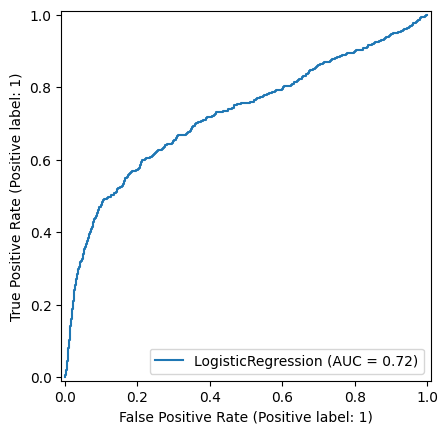

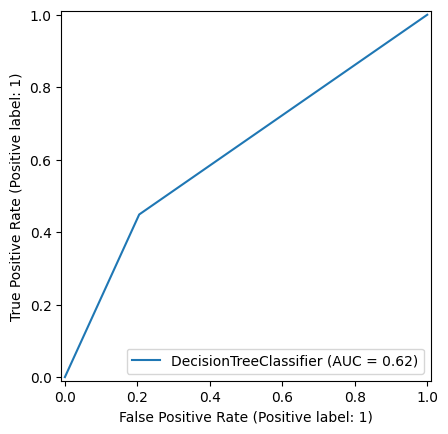

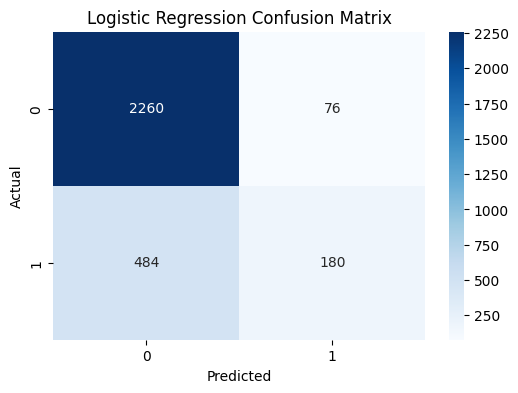

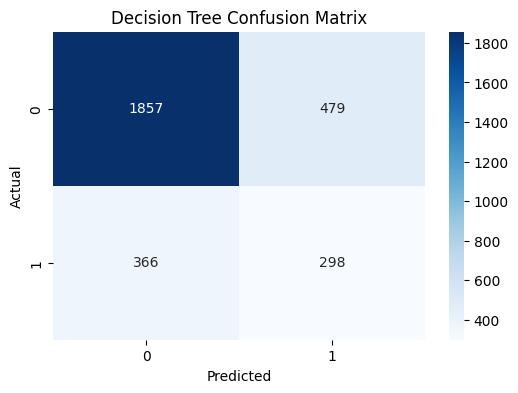

In [ ]:
#Additional Evaluation on Validation Set - Confusion Matrix and ROC-AUC
from sklearn.metrics import confusion_matrix, roc_auc_score, RocCurveDisplay

def additional_evaluation(model, X_val, y_val):
	y_pred = model.predict(X_val)
	y_proba = model.predict_proba(X_val)[:, 1]
	cm = confusion_matrix(y_val, y_pred)
	roc_auc = roc_auc_score(y_val, y_proba)
	RocCurveDisplay.from_estimator(model, X_val, y_val)
	return cm, roc_auc

log_reg_cm, log_reg_roc_auc = additional_evaluation(log_reg, X_val, y_val)
dec_tree_cm, dec_tree_roc_auc = additional_evaluation(dec_tree, X_val, y_val)

print("Logistic Regression - Confusion Matrix:\n", log_reg_cm)
print("Logistic Regression - ROC-AUC: {:.4f}".format(log_reg_roc_auc))
print("Decision Tree - Confusion Matrix:\n", dec_tree_cm)
print("Decision Tree - ROC-AUC: {:.4f}".format(dec_tree_roc_auc))

#Also display confusion matrix and ROC-AUC using seaborn heatmap
import seaborn as sns
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, title):
	plt.figure(figsize=(6, 4))
	sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
	plt.title(title)
	plt.xlabel('Predicted')
	plt.ylabel('Actual')
	plt.show()

plot_confusion_matrix(log_reg_cm, "Logistic Regression Confusion Matrix")
plot_confusion_matrix(dec_tree_cm, "Decision Tree Confusion Matrix")

Random Forest - Accuracy: 0.8203, Precision: 0.6632, Recall: 0.3825, F1-Score: 0.4852
Voting Classifier - Accuracy: 0.7183, Precision: 0.3835, Recall: 0.4488, F1-Score: 0.4136
AdaBoost - Accuracy: 0.7220, Precision: 0.3867, Recall: 0.4367, F1-Score: 0.4102
Random Forest - Confusion Matrix:
 [[2207  129]
 [ 410  254]]
Random Forest - ROC-AUC: 0.7830
Voting Classifier - Confusion Matrix:
 [[1857  479]
 [ 366  298]]
Voting Classifier - ROC-AUC: 0.7173
AdaBoost - Confusion Matrix:
 [[1876  460]
 [ 374  290]]
AdaBoost - ROC-AUC: 0.6199


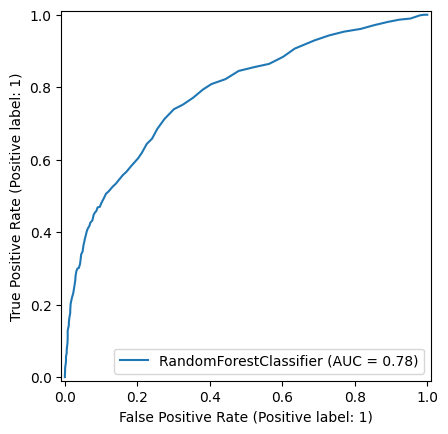

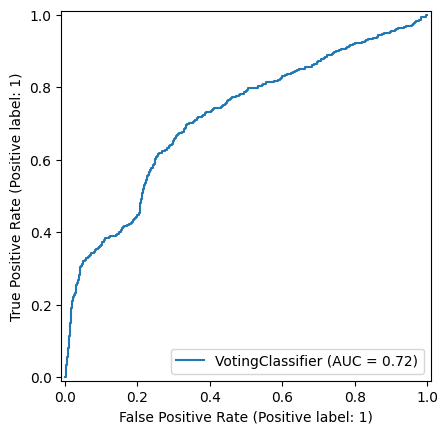

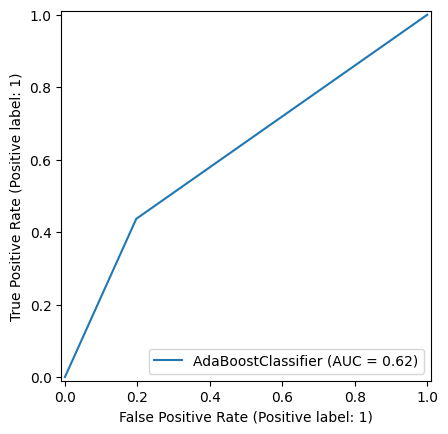

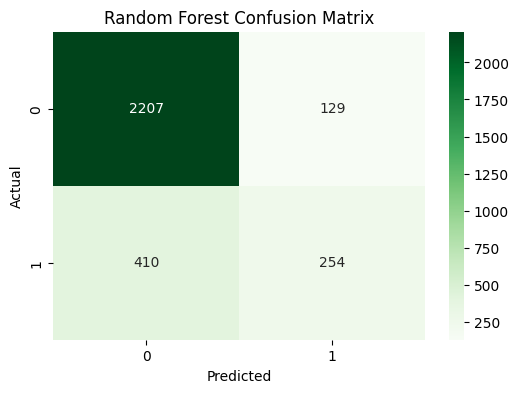

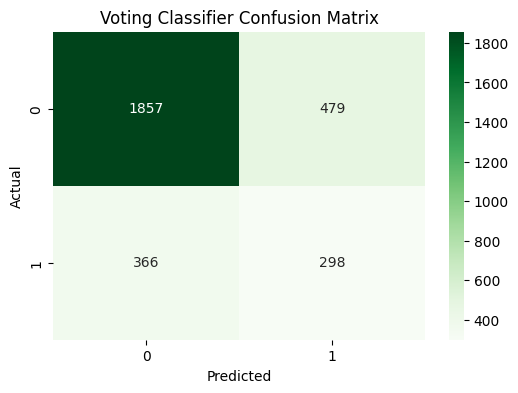

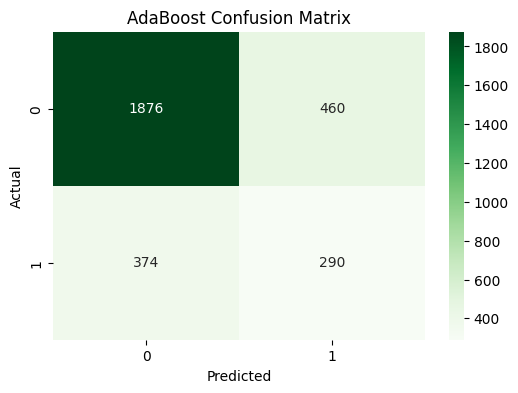

In [ ]:
#Ensemble Model (Random Forest, ensemble of Logistic Regression and Decision Tree, AdaBoost)
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=100)
voting_clf = VotingClassifier(estimators=[('log_reg', log_reg), ('dec_tree', dec_tree)], voting='soft')
ada_clf = AdaBoostClassifier(estimator=dec_tree, n_estimators=50, random_state=100)

rf_clf.fit(X_train, y_train)
voting_clf.fit(X_train, y_train)
ada_clf.fit(X_train, y_train)

rf_clf_metrics = evaluate_model(rf_clf, X_val, y_val)
voting_clf_metrics = evaluate_model(voting_clf, X_val, y_val)
ada_clf_metrics = evaluate_model(ada_clf, X_val, y_val)

print("Random Forest - Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1-Score: {:.4f}".format(*rf_clf_metrics))
print("Voting Classifier - Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1-Score: {:.4f}".format(*voting_clf_metrics))
print("AdaBoost - Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1-Score: {:.4f}".format(*ada_clf_metrics))

#Additional Evaluation for Ensemble Models
rf_cm, rf_roc_auc = additional_evaluation(rf_clf, X_val, y_val)
voting_cm, voting_roc_auc = additional_evaluation(voting_clf, X_val, y_val)
ada_cm, ada_roc_auc = additional_evaluation(ada_clf, X_val, y_val)
print("Random Forest - Confusion Matrix:\n", rf_cm)
print("Random Forest - ROC-AUC: {:.4f}".format(rf_roc_auc))
print("Voting Classifier - Confusion Matrix:\n", voting_cm)
print("Voting Classifier - ROC-AUC: {:.4f}".format(voting_roc_auc))
print("AdaBoost - Confusion Matrix:\n", ada_cm)
print("AdaBoost - ROC-AUC: {:.4f}".format(ada_roc_auc))

def plot_ensemble_confusion_matrix(cm, title):
	plt.figure(figsize=(6, 4))
	sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
	plt.title(title)
	plt.xlabel('Predicted')
	plt.ylabel('Actual')
	plt.show()

plot_ensemble_confusion_matrix(rf_cm, "Random Forest Confusion Matrix")
plot_ensemble_confusion_matrix(voting_cm, "Voting Classifier Confusion Matrix")
plot_ensemble_confusion_matrix(ada_cm, "AdaBoost Confusion Matrix")

